## Загрузка библиотек

In [ ]:
!pip install intvalpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for intvalpy: filename=intvalpy-1.6.6-py3-none-any.whl size=57830 sha256=e30de32a27ffec7db97c35c3b3fd33a24432676bf398ff527abc53536349eecc
  Stored in directory: /root/.cache/pip/wheels/66/12/98/3196993a49d4afd0cc7dcea440d9588b5c9de8c3b03c4842e1
Successfully built intvalpy


In [ ]:
import numpy as np
import struct
import intvalpy as ip
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
ip.precision.extendedPrecisionQ = False

##Основные функции

In [ ]:
# ===== 1. Чтение бинарных файлов =====

def read_thomson_bin(path):
    with open(path, 'rb') as f:
        header = f.read(256)
        side, mode, frame_count = struct.unpack('<BBH', header[:4])
        print(f"Side={side}, Mode={mode}, Frames={frame_count}")

        frames = []
        point_dtype = np.dtype('<8H')

        for _ in range(frame_count):
            frame_header_data = f.read(16)
            if len(frame_header_data) < 16:
                break
            stop_point, timestamp = struct.unpack('<HL', frame_header_data[:6])
            frame_data = np.frombuffer(f.read(1024 * 16), dtype=point_dtype)
            frames.append(frame_data)

    frames = np.array(frames)
    volts = frames / 16384.0 - 0.5
    return volts


# ===== 2. Интервальные операции =====

def union_intervals(x, y):
    a = min(float(x.a), float(y.a))
    b = max(float(x.b), float(y.b))
    return ip.Interval([a, b])


def intervals_intersect(x, y):
    res = ip.intersection(x, y)
    if np.isnan(res.a) and np.isnan(res.b):
        return False
    return True


def interval_mode(sample):
    if sample is None or len(sample) == 0:
        return None

    edges = []
    for x_i in sample:
        edges.append(float(x_i.a))
        edges.append(float(x_i.b))
    edges = sorted(edges)

    Z = [ip.Interval(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    mu = [sum(1 for x_i in sample if z_i in x_i) for z_i in Z]
    max_mu = max(mu)
    K = [idx for idx, val in enumerate(mu) if val == max_mu]
    m = [Z[k] for k in K]

    merged = []
    curr_int = m[0]
    for next_int in m[1:]:
        if intervals_intersect(curr_int, next_int):
            curr_int = union_intervals(curr_int, next_int)
        else:
            merged.append(curr_int)
            curr_int = next_int
    merged.append(curr_int)
    return merged


def kreinovich_median(sample):
    lowers = [float(el.a) for el in sample]
    uppers = [float(el.b) for el in sample]
    med_lower = float(np.median(lowers))
    med_upper = float(np.median(uppers))
    return ip.Interval([med_lower, med_upper])


def prolubnikov_median(sample):
    X = sorted(sample, key=lambda t: (float(t.a) + float(t.b)) / 2)
    index_med = len(X) // 2
    if len(X) % 2 == 0:
        return (X[index_med - 1] + X[index_med]) / 2
    return X[index_med]


# ===== 3. Жаккар =====

def jaccard_interval(x, y):
    a1, b1 = float(x.a), float(x.b)
    a2, b2 = float(y.a), float(y.b)

    numerator = min(b1, b2) - max(a1, a2)
    denominator = max(b1, b2) - min(a1, a2)
    if denominator == 0:
        return 0.0
    return numerator / denominator


def jaccard_one_set(X):
    lowers = [float(x.a) for x in X]
    uppers = [float(x.b) for x in X]
    numerator = min(uppers) - max(lowers)
    denominator = max(uppers) - min(lowers)
    if denominator == 0:
        return 0.0
    return numerator / denominator


def jaccard_two_sets(X, Y):
    coeffs = [jaccard_interval(x, y) for x, y in zip(X, Y)]
    return np.array(coeffs)


def jaccard_coeff(X, Y=None):
    if Y is None:
        return jaccard_one_set(X)

    if isinstance(X, ip.ClassicalArithmetic) and isinstance(Y, ip.ClassicalArithmetic):
        return jaccard_interval(X, Y)
    return jaccard_two_sets(X, Y)


# ===== 4. Золотое сечение =====

def golden_search(f, a, b, eps=1e-4):
    phi = (3 - np.sqrt(5)) / 2
    x1, x2 = a + phi * (b - a), b - phi * (b - a)
    f1, f2 = f(x1), f(x2)
    while abs(b - a) > eps:
        if f1 < f2:
            a, x1, f1 = x1, x2, f2
            x2 = b - phi * (b - a)
            f2 = f(x2)
        else:
            b, x2, f2 = x2, x1, f1
            x1 = a + phi * (b - a)
            f1 = f(x1)
    return (a + b) / 2


# ===== 5. Вспомогательные =====

def scalar_to_interval(x, rad):
    return ip.Interval(x - rad, x + rad)


scalar_to_interval_vec = np.vectorize(scalar_to_interval)


def avg_frames(data):
    return np.mean(data, axis=0)


In [ ]:
from tqdm import tqdm

def plot_functional(name, func_a, func_t, X, Y,
                    bound_a_l, bound_a_r, bound_t_l, bound_t_r,
                    n_points=100, eps=1e-3):
    """
    Строит графики F(a) и F(t), отмечает максимум и сохраняет
    картинку в файл <name>.png.
    Для медленных функционалов (особенно F2) добавлены прогресс-бары.
    """
    # --- Поиск экстремумов (золотое сечение, без прогресс-бара) ---
    print(f"\nПоиск максимума для {name} методом золотого сечения...")
    a_opt = golden_search(lambda a: func_a(a, X, Y), bound_a_l, bound_a_r, eps)
    t_opt = golden_search(lambda t: func_t(t, X, Y), bound_t_l, bound_t_r, eps)
    val_a = func_a(a_opt, X, Y)
    val_t = func_t(t_opt, X, Y)

    print(f"{name}: a* = {a_opt:.4f} (F={val_a:.4f}), t* = {t_opt:.4f} (F={val_t:.4f})")

    # --- Сетка по a и t ---
    a_values = np.linspace(bound_a_l, bound_a_r, n_points)
    t_values = np.linspace(bound_t_l, bound_t_r, n_points)

    Ji_a = []
    Ji_t = []

    print(f"\nВычисление {name}(a) на сетке из {n_points} точек...")
    for a in tqdm(a_values):
        Ji_a.append(func_a(a, X, Y))

    print(f"\nВычисление {name}(t) на сетке из {n_points} точек...")
    for t in tqdm(t_values):
        Ji_t.append(func_t(t, X, Y))

    Ji_a = np.array(Ji_a)
    Ji_t = np.array(Ji_t)

    # --- Поиск максимума по сетке для отображения ---
    idx_a_max = np.argmax(Ji_a)
    idx_t_max = np.argmax(Ji_t)
    a_opt_grid, val_a_grid = a_values[idx_a_max], Ji_a[idx_a_max]
    t_opt_grid, val_t_grid = t_values[idx_t_max], Ji_t[idx_t_max]

    print(f"\n{name} по сетке: a* ≈ {a_opt_grid:.4f} (F={val_a_grid:.4f}), "
          f"t* ≈ {t_opt_grid:.4f} (F={val_t_grid:.4f})")

    # --- Построение графиков ---
    plt.figure(figsize=(10, 4))

    # F(a)
    plt.subplot(1, 2, 1)
    plt.plot(a_values, Ji_a, label=f"{name}(a)")
    plt.axvline(x=a_opt_grid, color='red', linestyle='--',
                label=f"a* ≈ {a_opt_grid:.4f}")
    plt.scatter(a_opt_grid, val_a_grid, color='red')
    plt.title(f"{name}(a) — максимум a*")
    plt.xlabel("a")
    plt.ylabel("Jaccard")
    plt.legend()
    plt.grid(True)

    # F(t)
    plt.subplot(1, 2, 2)
    plt.plot(t_values, Ji_t, label=f"{name}(t)")
    plt.axvline(x=t_opt_grid, color='red', linestyle='--',
                label=f"t* ≈ {t_opt_grid:.4f}")
    plt.scatter(t_opt_grid, val_t_grid, color='red')
    plt.title(f"{name}(t) — максимум t*")
    plt.xlabel("t")
    plt.ylabel("Jaccard")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{name}.png", dpi=300)
    plt.show()
    plt.close()

##Подготовка данных

In [ ]:
# Замените имена файлов на свои, если другие
x_data = read_thomson_bin("-0.205_lvl_side_a_fast_data.bin")
y_data = read_thomson_bin("0.225_lvl_side_a_fast_data.bin")

rad = 2 ** (-14)
x_avg = avg_frames(x_data)
y_avg = avg_frames(y_data)

X = scalar_to_interval_vec(x_avg, rad).flatten()
Y = scalar_to_interval_vec(y_avg, rad).flatten()

bound_a_l = float(np.min(Y).a) - float(np.max(X).b)
bound_a_r = float(np.max(Y).b) - float(np.min(X).a)

bound_t_l = float(np.min(Y).a) / float(np.max(X).b)
bound_t_r = float(np.max(Y).b) / float(np.min(X).a)

number = 100
eps_a = (bound_a_r - bound_a_l) / number
eps_t = (bound_t_r - bound_t_l) / number

print(f"\nДиапазон для a: [{bound_a_l:.4f}, {bound_a_r:.4f}], ε ≈ {eps_a:.4f}")
print(f"Диапазон для t: [{bound_t_l:.4f}, {bound_t_r:.4f}], ε ≈ {eps_t:.4f}")

Side=0, Mode=1, Frames=100
Side=0, Mode=1, Frames=100

Диапазон для a: [0.3217, 0.3705], ε ≈ 0.0005
Диапазон для t: [-1.0404, -1.0154], ε ≈ 0.0003


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Построение функционалов


Поиск максимума для F1 методом золотого сечения...
F1: a* = 0.3407 (F=-0.7864), t* = -1.0504 (F=-0.8611)

Вычисление F1(a) на сетке из 100 точек...


100%|██████████| 100/100 [00:05<00:00, 19.58it/s]



Вычисление F1(t) на сетке из 100 точек...


100%|██████████| 100/100 [00:05<00:00, 17.86it/s]



F1 по сетке: a* ≈ 0.3409 (F=-0.7867), t* ≈ -1.0509 (F=-0.8618)


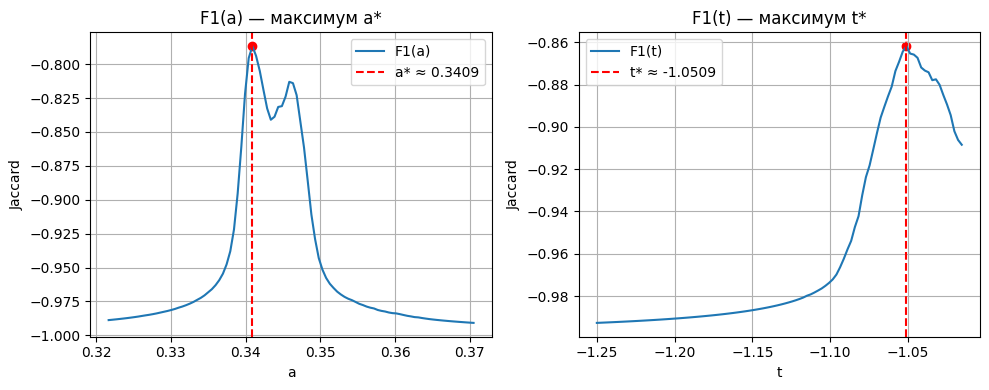

In [ ]:
# F1: Ji(X, Y)

def F1_a(a, X, Y):
    return np.mean(jaccard_coeff(X + a, Y))

def F1_t(t, X, Y):
    return np.mean(jaccard_coeff(X * t, Y))

plot_functional(
    "F1",
    func_a=F1_a,
    func_t=F1_t,
    X=X, Y=Y,
    bound_a_l=bound_a_l, bound_a_r=bound_a_r,
    bound_t_l=-1.25, bound_t_r=bound_t_r
)


Поиск максимума для F2 методом золотого сечения...
F2: a* = 0.3467 (F=-0.9967), t* = -1.0395 (F=-0.9121)

Вычисление F2(a) на сетке из 100 точек...


100%|██████████| 100/100 [1:49:06<00:00, 65.46s/it]



Вычисление F2(t) на сетке из 100 точек...


100%|██████████| 100/100 [1:49:48<00:00, 65.88s/it]



F2 по сетке: a* ≈ 0.3468 (F=-0.9932), t* ≈ -1.0391 (F=-0.9928)


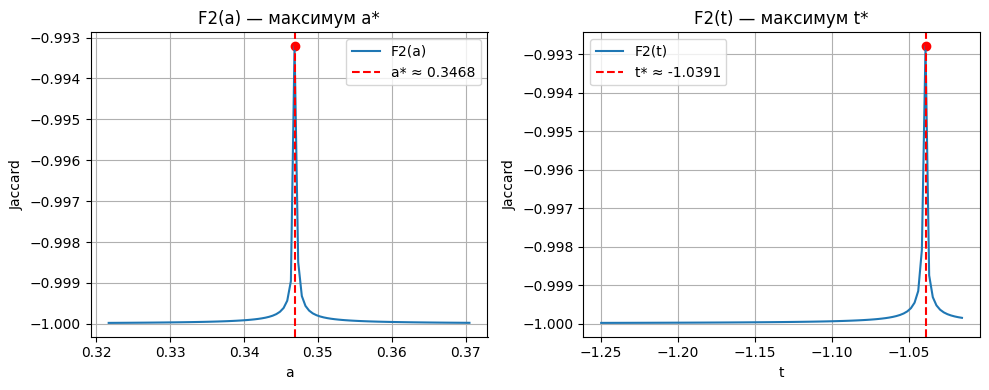

In [ ]:
# F2: Ji(mode(X), mode(Y))

def F2_a(a, X, Y):
    mode_X = interval_mode(X + a)
    mode_Y = interval_mode(Y)
    return np.mean(jaccard_coeff(mode_X, mode_Y))

def F2_t(t, X, Y):
    mode_X = interval_mode(X * t)
    mode_Y = interval_mode(Y)
    return np.mean(jaccard_coeff(mode_X, mode_Y))

plot_functional(
    "F2",
    func_a=F2_a,
    func_t=F2_t,
    X=X, Y=Y,
    bound_a_l=bound_a_l, bound_a_r=bound_a_r,
    bound_t_l=-1.25, bound_t_r=bound_t_r,
    n_points=100,
    eps=1e-3
)



Поиск максимума для F3 методом золотого сечения...
F3: a* = 0.3440 (F=-0.1797), t* = -1.0276 (F=0.6723)

Вычисление F3(a) на сетке из 100 точек...


100%|██████████| 100/100 [00:01<00:00, 53.31it/s]



Вычисление F3(t) на сетке из 100 точек...


100%|██████████| 100/100 [00:04<00:00, 23.28it/s]



F3 по сетке: a* ≈ 0.3444 (F=-0.1832), t* ≈ -1.0272 (F=0.1367)


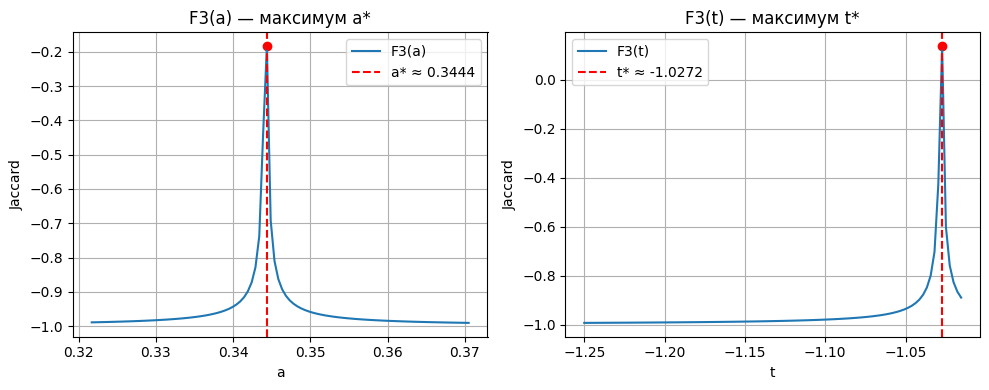

In [ ]:
# F3: Ji(medK(X), medK(Y))

def F3_a(a, X, Y):
    return np.mean(jaccard_coeff(kreinovich_median(X + a), kreinovich_median(Y)))

def F3_t(t, X, Y):
    return np.mean(jaccard_coeff(kreinovich_median(X * t), kreinovich_median(Y)))

plot_functional(
    "F3",
    func_a=F3_a,
    func_t=F3_t,
    X=X, Y=Y,
    bound_a_l=bound_a_l, bound_a_r=bound_a_r,
    bound_t_l=-1.25, bound_t_r=bound_t_r,
    n_points=100,
    eps=1e-3
)



Поиск максимума для F4 методом золотого сечения...
F4: a* = 0.3440 (F=-0.1797), t* = -1.0276 (F=0.6723)

Вычисление F4(a) на сетке из 100 точек...


100%|██████████| 100/100 [00:02<00:00, 41.76it/s]



Вычисление F4(t) на сетке из 100 точек...


100%|██████████| 100/100 [00:04<00:00, 22.63it/s]



F4 по сетке: a* ≈ 0.3444 (F=-0.1832), t* ≈ -1.0272 (F=0.1367)


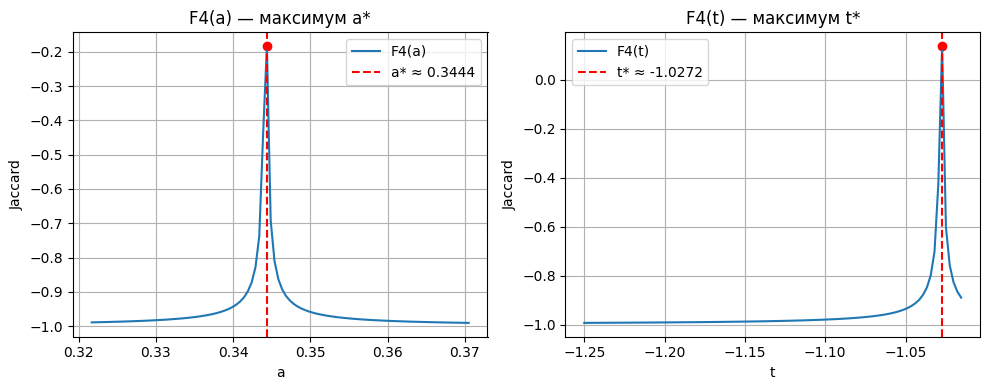

In [ ]:
# F4: Ji(medP(X), medP(Y))

def F4_a(a, X, Y):
    return np.mean(jaccard_coeff(prolubnikov_median(X + a), prolubnikov_median(Y)))

def F4_t(t, X, Y):
    return np.mean(jaccard_coeff(prolubnikov_median(X * t), prolubnikov_median(Y)))

plot_functional(
    "F4",
    func_a=F4_a,
    func_t=F4_t,
    X=X, Y=Y,
    bound_a_l=bound_a_l, bound_a_r=bound_a_r,
    bound_t_l=-1.25, bound_t_r=bound_t_r,
    n_points=100,
    eps=1e-3
)